In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import torch
import torchvision
import torchsummary
import torchmetrics
from sklearn.metrics import average_precision_score
from torch.utils.tensorboard import SummaryWriter

In [3]:
from utils import do_train, predict_test

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
if torch.cuda.is_available():
    print('There is GPU')

There is GPU


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data Visualization

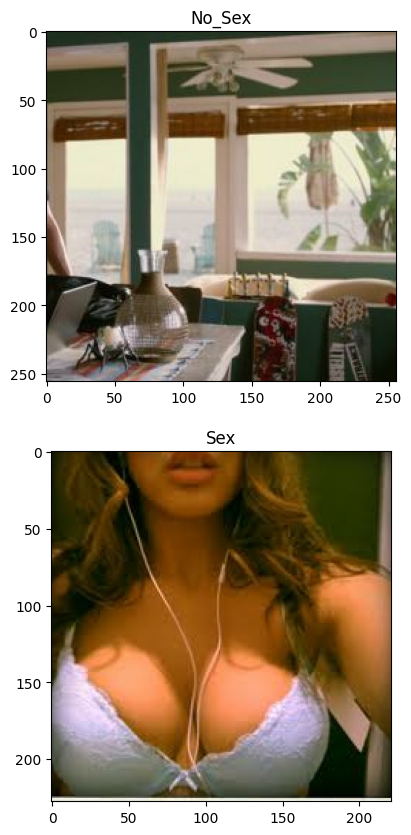

In [7]:
no_sex_image_name = random.choice(os.listdir("P2datasetFull/train/1"))
no_sex = mpimg.imread(os.path.join("P2datasetFull/train/1", no_sex_image_name))
sex_image_name = random.choice(os.listdir("P2datasetFull/train/2"))
sex_image = mpimg.imread(os.path.join("P2datasetFull/train/2", sex_image_name))

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].imshow(no_sex) 
axs[0].title.set_text('No_Sex') 

axs[1].imshow(sex_image)
axs[1].title.set_text('Sex')

# Utilizar Datos

In [8]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [9]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='P2datasetFull/train/', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='P2datasetFull/val1/', transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(root='P2datasetFull/test1/', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [10]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                    [-1, 2]           1,026
Total params: 5,407,394
Trainable params: 5,407,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.63
Estima

In [11]:
NAME_MODEL = 'CONV_BASE_MODEL'

In [12]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.0001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_train"),
                "valid": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_valid")}

history = do_train(noaug_conv_model, 
                noaug_optimizer, 
                noaug_loss, 
                noaug_metric,
                noaug_data,
                20,
                device,
                noaug_writer)

Epoch: 1/20 - Train loss 0.563603 - Train Accuracy 0.710545 - Valid Loss 0.541053 - Valid Accuracy 0.729586
Epoch: 2/20 - Train loss 0.468392 - Train Accuracy 0.780060 - Valid Loss 0.495667 - Valid Accuracy 0.757877
Epoch: 3/20 - Train loss 0.436914 - Train Accuracy 0.793870 - Valid Loss 0.490869 - Valid Accuracy 0.767000
Epoch: 4/20 - Train loss 0.408121 - Train Accuracy 0.809875 - Valid Loss 0.449955 - Valid Accuracy 0.790656
Epoch: 5/20 - Train loss 0.381971 - Train Accuracy 0.829719 - Valid Loss 0.432716 - Valid Accuracy 0.801529
Epoch: 6/20 - Train loss 0.369371 - Train Accuracy 0.833877 - Valid Loss 0.441046 - Valid Accuracy 0.797695
Epoch: 7/20 - Train loss 0.347943 - Train Accuracy 0.844952 - Valid Loss 0.444292 - Valid Accuracy 0.799051
Epoch: 8/20 - Train loss 0.333193 - Train Accuracy 0.857229 - Valid Loss 0.408824 - Valid Accuracy 0.816519
Epoch: 9/20 - Train loss 0.316904 - Train Accuracy 0.860577 - Valid Loss 0.416777 - Valid Accuracy 0.821092
Epoch: 10/20 - Train loss 0.

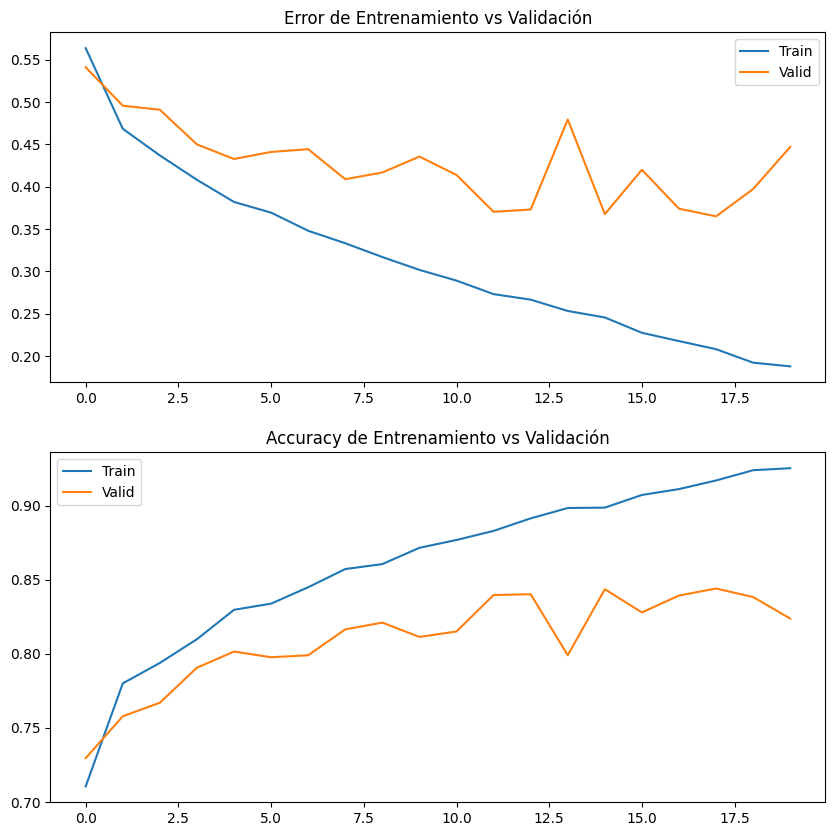

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

# Prediction

In [14]:
noaug_conv_model.eval()

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [142]:
predict_test(noaug_conv_model, test_loader)

Total images: 6216
PR_AUC: 0.9225488726003163
Accuracy: 81.98198198198199


# Aplicando Data Augmentation

In [143]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

aug_train_set = torchvision.datasets.ImageFolder(root='P2datasetFull/train/', transform=aug_data_transforms)
aug_valid_set = torchvision.datasets.ImageFolder(root='P2datasetFull/val1/', transform=data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=32, shuffle=True)

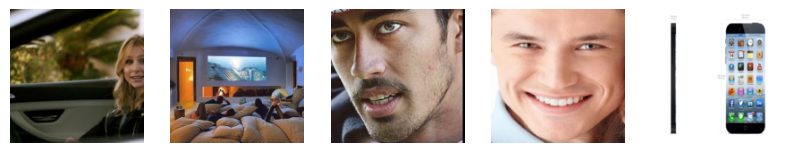

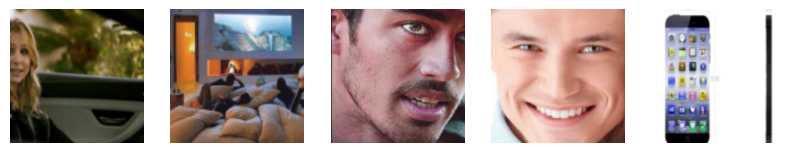

In [148]:
images_ids = np.random.randint(low=0, high=len(train_set), size=5)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

for id, row in enumerate(rows):
    row.imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

In [21]:
NAME_MODEL = 'CONV_AUGMENTATION'

In [22]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.0001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_train"),
                "valid": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_valid")}

history = do_train(aug_conv_model, 
                aug_optimizer, 
                aug_loss, 
                aug_metric,
                aug_data,
                20,
                device,
                aug_writer)

Epoch: 1/20 - Train loss 0.571487 - Train Accuracy 0.690615 - Valid Loss 0.524361 - Valid Accuracy 0.750505
Epoch: 2/20 - Train loss 0.506313 - Train Accuracy 0.757972 - Valid Loss 0.491250 - Valid Accuracy 0.773397
Epoch: 3/20 - Train loss 0.479156 - Train Accuracy 0.772199 - Valid Loss 0.533517 - Valid Accuracy 0.754586
Epoch: 4/20 - Train loss 0.460752 - Train Accuracy 0.781667 - Valid Loss 0.525132 - Valid Accuracy 0.763646
Epoch: 5/20 - Train loss 0.437021 - Train Accuracy 0.794422 - Valid Loss 0.525094 - Valid Accuracy 0.770131
Epoch: 6/20 - Train loss 0.426815 - Train Accuracy 0.801989 - Valid Loss 0.450363 - Valid Accuracy 0.798410
Epoch: 7/20 - Train loss 0.405387 - Train Accuracy 0.821134 - Valid Loss 0.442531 - Valid Accuracy 0.806102
Epoch: 8/20 - Train loss 0.397785 - Train Accuracy 0.820729 - Valid Loss 0.546000 - Valid Accuracy 0.765976
Epoch: 9/20 - Train loss 0.394030 - Train Accuracy 0.822471 - Valid Loss 0.434597 - Valid Accuracy 0.810096
Epoch: 10/20 - Train loss 0.

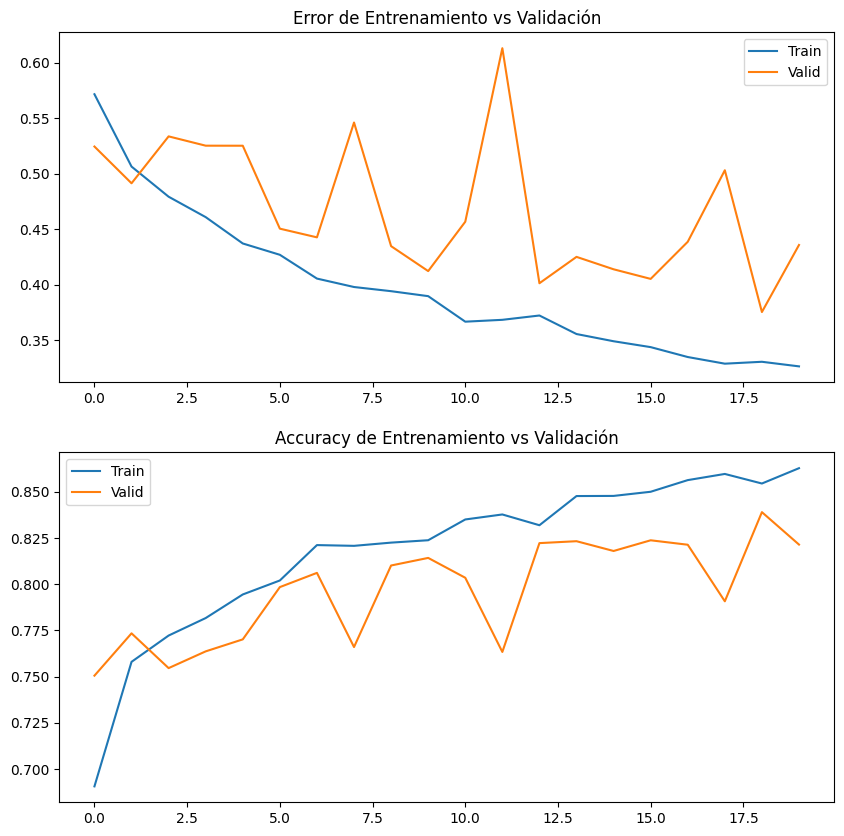

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [141]:
predict_test(aug_conv_model, test_loader)

Total images: 6216
PR_AUC: 0.9296679084180411
Accuracy: 83.23680823680823


# Albumentations

In [25]:
import os
import cv2
import numpy as np

from torch.utils.data import Dataset

class AlbumImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []

        classes = sorted(entry.name for entry in os.scandir(self.root) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(self.root, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.samples[idx][-1]
        file_path = self.samples[idx][0]
        
        image = cv2.imread(file_path)
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            print(file_path)
            
        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label

In [63]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

albumentations_aug_data_transforms = A.Compose([
                                        A.Resize(ANCHO_IMAGENES, ALTO_IMAGENES),
                                        #A.HorizontalFlip(0.5),
                                        #A.ShiftScaleRotate(rotate_limit=30, border_mode=0),
                                        A.RandomResizedCrop(ANCHO_IMAGENES, ALTO_IMAGENES, scale=(0.5, 1.0)), 
                                        A.ColorJitter(saturation=0.1, hue=0.1),
                                        # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                        ToTensorV2(),
                                     ])

albumentations_data_transforms = A.Compose([
                                    A.Resize(ANCHO_IMAGENES, ALTO_IMAGENES),
                                    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                    ToTensorV2()
                                 ])

albumentations_train_set = AlbumImageFolder(root='P2datasetFull/train/', transform=albumentations_aug_data_transforms)
albumentations_valid_set = AlbumImageFolder(root='P2datasetFull/val1/', transform=albumentations_data_transforms)

albu_train_loader = torch.utils.data.DataLoader(albumentations_train_set, batch_size=32, shuffle=True)
albu_valid_loader = torch.utils.data.DataLoader(albumentations_valid_set, batch_size=32, shuffle=True)

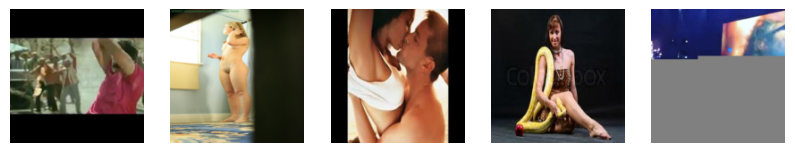

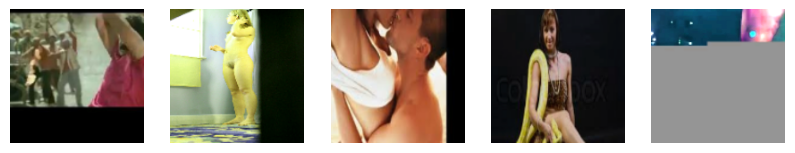

In [150]:
images_ids = np.random.randint(low=0, high=len(train_set), size=5)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

for id, row in enumerate(rows):
    row.imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

for id, row in enumerate(rows):
    row.imshow(albumentations_train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

In [65]:
NAME_MODEL = 'CONV_ALBUMENTATION'

In [66]:
albu_model = ConvModel(CANTIDAD_CLASES)
albu_optimizer = torch.optim.Adam(albu_model.parameters(), lr=0.0001)
albu_criterion = torch.nn.CrossEntropyLoss()
albu_metric = torchmetrics.Accuracy(task='multiclass', num_classes=2)
albu_data = {"train": albu_train_loader, "valid": albu_valid_loader,
             "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

albu_writer = {"train": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_train"),
                "valid": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_valid")}

history = do_train(albu_model, 
                albu_optimizer, 
                albu_criterion, 
                albu_metric,
                albu_data,
                20,
                device,
                albu_writer)

Epoch: 1/20 - Train loss 0.645769 - Train Accuracy 0.719805 - Valid Loss 0.518222 - Valid Accuracy 0.779426
Epoch: 2/20 - Train loss 0.477268 - Train Accuracy 0.779999 - Valid Loss 0.498920 - Valid Accuracy 0.790076
Epoch: 3/20 - Train loss 0.451972 - Train Accuracy 0.791724 - Valid Loss 0.469120 - Valid Accuracy 0.797522
Epoch: 4/20 - Train loss 0.409892 - Train Accuracy 0.810906 - Valid Loss 0.465816 - Valid Accuracy 0.807396
Epoch: 5/20 - Train loss 0.396609 - Train Accuracy 0.822238 - Valid Loss 0.478786 - Valid Accuracy 0.807865
Epoch: 6/20 - Train loss 0.370500 - Train Accuracy 0.832123 - Valid Loss 0.460143 - Valid Accuracy 0.823323
Epoch: 7/20 - Train loss 0.353387 - Train Accuracy 0.846546 - Valid Loss 0.517606 - Valid Accuracy 0.802909
Epoch: 8/20 - Train loss 0.338111 - Train Accuracy 0.853402 - Valid Loss 0.583858 - Valid Accuracy 0.769255
Epoch: 9/20 - Train loss 0.325282 - Train Accuracy 0.860417 - Valid Loss 0.459310 - Valid Accuracy 0.825814
Epoch: 10/20 - Train loss 0.

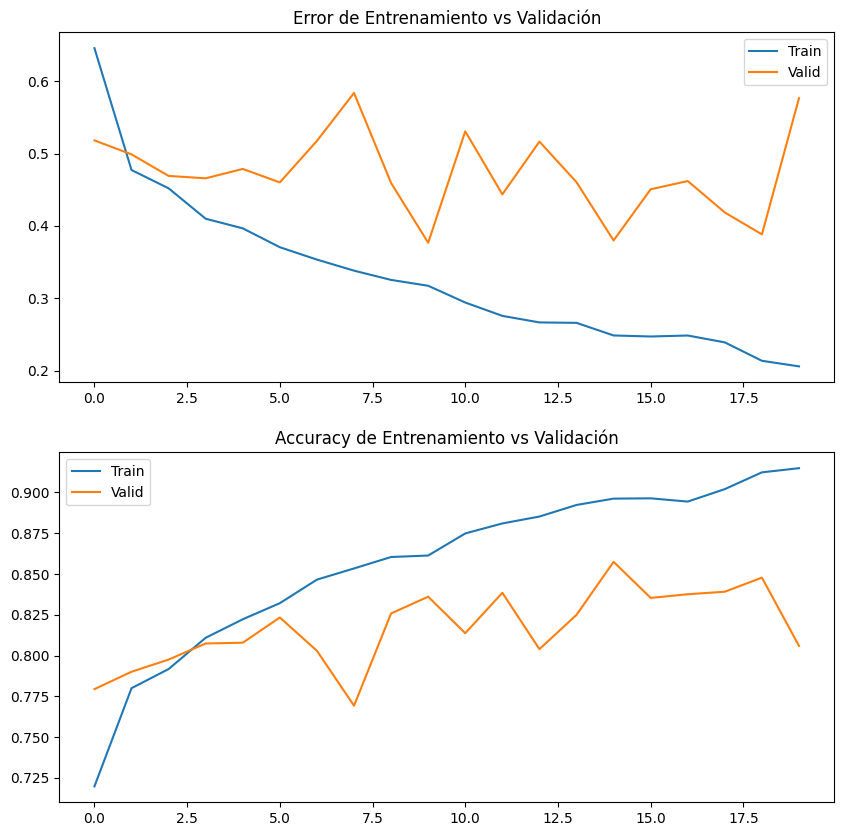

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [138]:
predict_test(albu_model, test_loader)

Total images: 6216
PR_AUC: 0.5440119558939063
Accuracy: 50.72393822393823


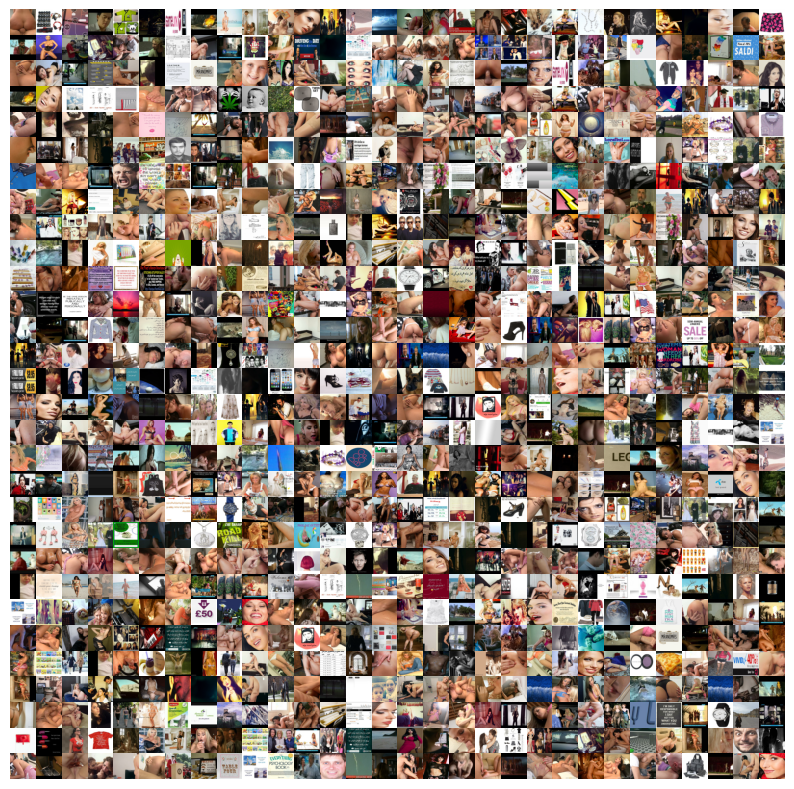

In [109]:
nrows, ncols = 30, 30
images_ids = np.random.randint(low=0, high=len(train_set), size=nrows * ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

id = 0
for row in range(nrows):
    for col in range(ncols):
        axs[row, col].imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
        axs[row, col].axis('off')
        id += 1
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [125]:
import seedir as sd

In [128]:
sd.seedir('P2datasetFull', style='emoji', depthlimit=2)

📁 P2datasetFull/
├─📁 test1/
│ ├─📁 1/
│ └─📁 2/
├─📁 val1/
│ ├─📁 1/
│ └─📁 2/
└─📁 train/
  ├─📁 1/
  └─📁 2/


In [137]:
len(os.listdir('P2datasetFull/test1/1'))

3153